## Noções de IA - Trabalho 1 - Regressão Linear na qualidade de vinho
##### Integrantes:
            - Lucas Corrêa Boaventura           - 211038262
            - Alexandre Castanho Sampaio Rocha  - 

In [181]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

### Classes


In [182]:
class LinearRegression(d2l.Module): #@save
    """The linear regression model implemented with high-level APIs."""
    """Do d2l"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [183]:
class LinearRegressionData(d2l.DataModule): #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]

@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
    buffer_size=shuffle_buffer).batch(self.batch_size)
    
@d2l.add_to_class(LinearRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

### Métodos de Treinamento

In [184]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

### Preparando os dados:

In [209]:
data = pd.read_csv('winequalityN.csv')
data = pd.get_dummies(data[data.columns.to_list()[::-1]]) # inverto para a qualidade estar na coluna 1 e adicionar os dummies nas úlimas colunas
data = data[data.columns.to_list()[::-1]] # reinverto para qualidade estar na última coluna
nInputs = len(data.columns) - 1
for key in data.columns: # preencher valores valtosos (NaN) pela média da coluna
    data[key] = data[key].fillna(data[key].mean())
    
data


,type_white,type_red,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,True,False,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,6
1,True,False,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,6
2,True,False,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,6
3,True,False,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
4,True,False,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,False,True,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,5
6493,False,True,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,6
6494,False,True,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,6
6495,False,True,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,5


In [212]:
train_data, val_data = train_test_split(data, test_size=0.2)
train_data_matrix = tf.convert_to_tensor(train_data, dtype=tf.double)
val_data_matrix = tf.convert_to_tensor(val_data, dtype=tf.double)
data_matrix = tf.concat((train_data_matrix, val_data_matrix),axis=0)
data_matrix


<tf.Tensor: shape=(6497, 14), dtype=float64, numpy=
array([[ 1.  ,  0.  ,  8.3 , ...,  0.56,  9.1 ,  6.  ],
       [ 1.  ,  0.  ,  6.3 , ...,  0.47, 12.8 ,  7.  ],
       [ 1.  ,  0.  ,  7.2 , ...,  0.76,  9.4 ,  5.  ],
       ...,
       [ 1.  ,  0.  ,  8.8 , ...,  0.47, 11.2 ,  5.  ],
       [ 0.  ,  1.  , 10.2 , ...,  0.63, 11.8 ,  6.  ],
       [ 1.  ,  0.  ,  7.6 , ...,  0.43, 13.1 ,  6.  ]])>

In [217]:
#Wopt= inv (XT X) XT Y

Xb = tf.concat((data_matrix[:,0:nInputs], tf.ones((6497, 1),dtype=tf.double)),axis=1)
y=data_matrix[:,nInputs]
#quad=tf.matmul(tf.transpose(Xb),Xb)
#quad
W=tf.linalg.matvec(tf.linalg.matmul(tf.linalg.inv(tf.matmul(tf.transpose(Xb),Xb)),tf.transpose(Xb)),y)
#yhat=tf.linalg.matvec(Xb,W)
#yhat[0:5]
W

<tf.Tensor: shape=(14,), dtype=float64, numpy=
array([ 7.43011719e+02,  7.12386719e+02,  8.48257124e-02, -1.48894237e+00,
       -6.07625110e-02,  6.24849077e-02, -7.69513039e-01,  4.93139670e-03,
       -1.41086914e-03, -1.04005678e+02,  4.95887418e-01,  7.24766700e-01,
        2.22394643e-01, -6.40468750e+02])>

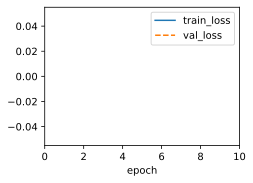

In [214]:
model = d2l.LinearRegression(lr=0.03)
lr_data = LinearRegressionData(nInputs,data_matrix)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, lr_data)

### Checar a estimativa de erro

In [ ]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.get_weights()[0], self.get_weights()[1])

w, b = model.get_w_b()
print((w,b))
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')